In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!pip install clean-fid
!pip install scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from cleanfid import fid
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [21]:
animals_path = "/content/drive/MyDrive/Task 2/animals"
butterfly_path = "/content/drive/MyDrive/Task 2/butterfly"

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [22]:
animals_data = datasets.ImageFolder(animals_path, transform)
butterfly_data = datasets.ImageFolder(butterfly_path, transform)

task1_dataset = torch.utils.data.ConcatDataset([animals_data, butterfly_data])
task1_loader = DataLoader(task1_dataset, batch_size=32, shuffle=True)

task_butterfly_loader = DataLoader(butterfly_data, batch_size=32, shuffle=True)

print("Animals:", len(animals_data))
print("Butterflies:", len(butterfly_data))


Animals: 5316
Butterflies: 60


In [23]:
# ---------------- Encoder ----------------
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,4,2,1), nn.ReLU(),
            nn.Conv2d(32,64,4,2,1), nn.ReLU(),
            nn.Conv2d(64,128,4,2,1), nn.ReLU(),
            nn.Conv2d(128,256,4,2,1), nn.ReLU(),
            nn.Conv2d(256,512,4,2,1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

# ---------------- Decoder ----------------
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512*4*4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(32,3,4,2,1), nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1,512,4,4)
        return self.deconv(x)

# ---------------- VAE Wrapper ----------------
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def sample_z(self, mu, logvar, n_samples=1):
        std = torch.exp(0.5*logvar)
        eps = torch.randn(n_samples, mu.size(0), mu.size(1)).to(mu.device)
        return mu + eps*std

    def forward(self, x, n_samples=1):
        mu, logvar = self.encoder(x)
        z = self.sample_z(mu, logvar, n_samples)
        return self.decoder(z[0]), mu, logvar


In [24]:
vae = VAE(latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=2e-4)

def vae_loss(x, x_hat, mu, logvar):
    recon = nn.functional.mse_loss(x_hat, x, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl

# -------- z=1 (4 epochs) --------
print("Training z=1 ...")
for epoch in range(4):
    for imgs, _ in task1_loader:
        imgs = imgs.to(device)
        x_hat, mu, logvar = vae(imgs, n_samples=1)
        loss, _, _ = vae_loss(imgs, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/4 Loss={loss.item():.4f}")

# -------- z=5 (1 epoch) --------
print("\nTraining z=5 ...")
for epoch in range(1):
    for imgs, _ in task1_loader:
        imgs = imgs.to(device)
        x_hat, mu, logvar = vae(imgs, n_samples=5)
        loss, _, _ = vae_loss(imgs, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("z=5 done, Loss=", loss.item())

# -------- z=10 (50 batches) --------
print("\nTraining z=10 ...")
for i, (imgs, _) in enumerate(task1_loader):
    if i > 50: break
    imgs = imgs.to(device)
    x_hat, mu, logvar = vae(imgs, n_samples=10)
    loss, _, _ = vae_loss(imgs, x_hat, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("🎉 Finished FULL VAE Training!")


Training z=1 ...
Epoch 1/4 Loss=0.2754
Epoch 2/4 Loss=0.2419
Epoch 3/4 Loss=0.2145
Epoch 4/4 Loss=0.2262

Training z=5 ...
z=5 done, Loss= 0.19376400113105774

Training z=10 ...
🎉 Finished FULL VAE Training!


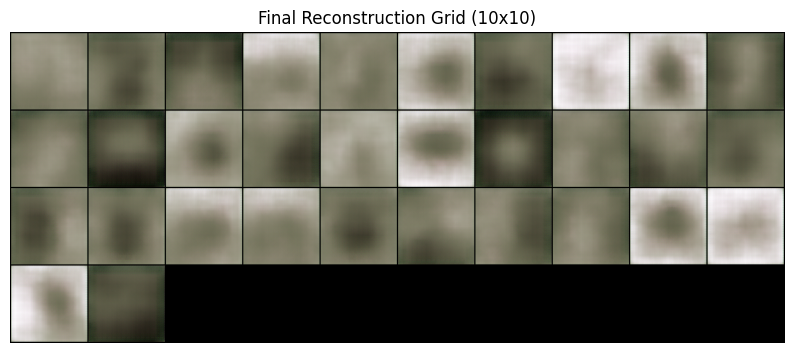

In [25]:
vae.eval()
imgs, _ = next(iter(task1_loader))
imgs = imgs[:100].to(device)

recon, _, _ = vae(imgs)

grid = vutils.make_grid(recon.cpu(), nrow=10, normalize=True)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid,(1,2,0)))
plt.title("Final Reconstruction Grid (10x10)")
plt.axis("off")
plt.show()


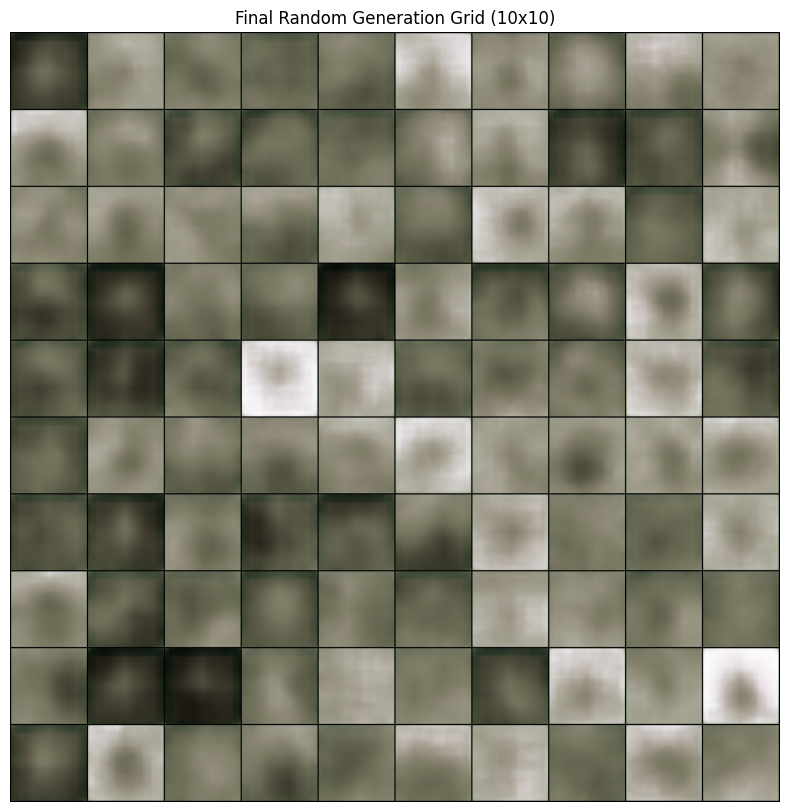

In [26]:
z = torch.randn(100, 128).to(device)
gen = vae.decoder(z)

grid = vutils.make_grid(gen.cpu(), nrow=10, normalize=True)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid,(1,2,0)))
plt.title("Final Random Generation Grid (10x10)")
plt.axis("off")
plt.show()


In [30]:
# ----- CELL 8: FID SCORE -----

import os
gen_dir = "/content/generated_vae_final"
os.makedirs(gen_dir, exist_ok=True)

LATENT_DIM = 128  # your VAE latent size

print("Generating 1000 images for FID...")

vae.eval()
with torch.no_grad():
    for i in range(1000):
        z = torch.randn(1, LATENT_DIM).to(device)   # FIXED SIZE
        img = vae.decoder(z).cpu()
        vutils.save_image(img, f"{gen_dir}/{i}.png", normalize=True)

print("Computing FID (using Animals dataset as reference)...")
fid_score = fid.compute_fid(gen_dir, animals_path)

print("FID Score:", fid_score)


Generating 1000 images for FID...
Computing FID (using Animals dataset as reference)...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 1000 images in the folder /content/generated_vae_final


FID generated_vae_final : 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]


Found 5316 images in the folder /content/drive/MyDrive/Task 2/animals


FID animals : 100%|██████████| 167/167 [02:38<00:00,  1.05it/s]


FID Score: 249.1261338201793


In [31]:
# -------- CELL 9: CNN CLASSIFIER (Butterfly Only) --------

from torchvision.models import resnet18
import torch.nn.functional as F

# Load Butterfly dataset again (train/test split)
from torch.utils.data import random_split

total = len(butterfly_data)
train_len = int(0.8 * total)
test_len = total - train_len
train_data, test_data = random_split(butterfly_data, [train_len, test_len])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

num_classes = len(butterfly_data.classes)
print("Butterfly classes:", num_classes)

# Use ResNet18
cnn = resnet18(weights=None)
cnn.fc = nn.Linear(512, num_classes)
cnn = cnn.to(device)

optimizer_cnn = optim.Adam(cnn.parameters(), lr=1e-3)

print("Training CNN Classifier...")
for epoch in range(5):
    cnn.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = cnn(imgs)
        loss = F.cross_entropy(logits, labels)

        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss={total_loss:.3f}")

# Evaluate
cnn.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        pred = cnn(imgs).argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

acc_cnn = 100 * correct / total
print("CNN Test Accuracy:", acc_cnn)


Butterfly classes: 1
Training CNN Classifier...
Epoch 1 Loss=0.000
Epoch 2 Loss=0.000
Epoch 3 Loss=0.000
Epoch 4 Loss=0.000
Epoch 5 Loss=0.000
CNN Test Accuracy: 100.0


In [32]:
# -------- CELL 10: Extract VAE Latent Vectors --------

vae.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for imgs, labels in DataLoader(butterfly_data, batch_size=16):
        imgs = imgs.to(device)
        mu, logvar = vae.encoder(imgs)
        latent_vectors.append(mu.cpu())
        labels_list.append(labels)

latent_vectors = torch.cat(latent_vectors)
labels_list = torch.cat(labels_list)

print("Latent shape:", latent_vectors.shape)
print("Labels:", labels_list.shape)


Latent shape: torch.Size([60, 128])
Labels: torch.Size([60])


In [33]:
# -------- CELL 11: MLP CLASSIFIER ON LATENT SPACE --------

class MLP(nn.Module):
    def __init__(self, input_dim=128, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.model(x)

mlp = MLP(128, num_classes).to(device)
opt_mlp = optim.Adam(mlp.parameters(), lr=1e-3)

X = latent_vectors.to(device)
Y = labels_list.to(device)

print("Training MLP on VAE latents...")
for epoch in range(20):
    logits = mlp(X)
    loss = F.cross_entropy(logits, Y)

    opt_mlp.zero_grad()
    loss.backward()
    opt_mlp.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} Loss={loss.item():.4f}")

# Accuracy
pred = mlp(X).argmax(1)
acc_latent = (pred == Y).float().mean().item()*100
print("MLP Accuracy on Latent Space:", acc_latent)


Training MLP on VAE latents...
Epoch 5 Loss=0.0000
Epoch 10 Loss=0.0000
Epoch 15 Loss=0.0000
Epoch 20 Loss=0.0000
MLP Accuracy on Latent Space: 100.0


In [34]:
# -------- CELL 12: VQ-VAE Model --------

class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size=128, dim=64):
        super().__init__()
        self.embedding = nn.Embedding(codebook_size, dim)
        self.embedding.weight.data.uniform_(-1, 1)

    def forward(self, z):
        B, C, H, W = z.shape
        z_flat = z.transpose(1,3).reshape(-1, C)
        dist = (
            z_flat.pow(2).sum(1, keepdim=True)
            - 2 * z_flat @ self.embedding.weight.t()
            + self.embedding.weight.pow(2).sum(1)
        )
        indices = dist.argmin(1)
        z_q = self.embedding(indices).view(B, H, W, C).permute(0,3,1,2)
        loss = F.mse_loss(z_q.detach(), z) + 0.25 * F.mse_loss(z_q, z.detach())
        return z_q, loss, indices


class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,4,2,1), nn.ReLU(),
            nn.Conv2d(32,64,4,2,1), nn.ReLU(),
        )
        self.quant = VectorQuantizer(128, 64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(32,3,4,2,1), nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_q, loss, indices = self.quant(z)
        x_hat = self.decoder(z_q)
        return x_hat, loss, indices


In [35]:
# -------- CELL 13: Train VQ-VAE --------

vqvae = VQVAE().to(device)
opt_vq = optim.Adam(vqvae.parameters(), lr=1e-3)

print("Training VQ-VAE (FAST)...")
for epoch in range(8):
    for imgs, _ in task_butterfly_loader:
        imgs = imgs.to(device)
        x_hat, vqloss, _ = vqvae(imgs)
        rec = F.mse_loss(x_hat, imgs)
        loss = rec + vqloss

        opt_vq.zero_grad()
        loss.backward()
        opt_vq.step()
    print(f"Epoch {epoch+1}/8 Loss={loss.item():.4f}")

print("VQ-VAE Training Done!")


Training VQ-VAE (FAST)...
Epoch 1/8 Loss=0.6843
Epoch 2/8 Loss=0.7257
Epoch 3/8 Loss=0.6455
Epoch 4/8 Loss=0.5920
Epoch 5/8 Loss=0.5504
Epoch 6/8 Loss=0.5583
Epoch 7/8 Loss=0.6023
Epoch 8/8 Loss=0.6055
VQ-VAE Training Done!


In [42]:
imgs, lbl = next(iter(DataLoader(butterfly_data, batch_size=16)))
imgs = imgs.to(device)
_, _, idx_test = vqvae(imgs)
print("idx_test shape:", idx_test.shape)


idx_test shape: torch.Size([16384])


In [44]:
# -------- CELL 14: Extract VQ Latents (FINAL FIX) --------

vqvae.eval()
vq_vectors = []
labels_vq = []

# IMPORTANT: BATCH SIZE = 1
loader = DataLoader(butterfly_data, batch_size=1, shuffle=False)

with torch.no_grad():
    for imgs, lbl in loader:
        imgs = imgs.to(device)
        _, _, idx = vqvae(imgs)     # idx shape = (16384,)

        HW = idx.size(0)            # 16384
        S = int(HW**0.5)            # 128

        # reshape into (1, 128, 128)
        idx = idx.view(1, S, S)

        # pool -> (1,)
        idx_pooled = idx.float().mean(dim=(1,2))   # (1,)

        vq_vectors.append(idx_pooled.cpu())
        labels_vq.append(lbl)

vq_vectors = torch.cat(vq_vectors)   # shape = (N,)
labels_vq = torch.cat(labels_vq)     # shape = (N,)

print("Final VQ Latent shape:", vq_vectors.shape)

# MLP input = 1
mlp_vq = MLP(input_dim=1, num_classes=num_classes).to(device)
opt_vq_mlp = optim.Adam(mlp_vq.parameters(), lr=1e-3)

Xvq = vq_vectors.unsqueeze(1).float().to(device)
Yvq = labels_vq.to(device)

print("Training MLP on VQ-VAE Latents...")
for epoch in range(25):
    out = mlp_vq(Xvq)
    loss = F.cross_entropy(out, Yvq)

    opt_vq_mlp.zero_grad()
    loss.backward()
    opt_vq_mlp.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} Loss={loss.item():.4f}")

pred = mlp_vq(Xvq).argmax(1)
acc_vq = (pred == Yvq).float().mean().item()*100
print("MLP Accuracy on VQ Latents:", acc_vq)


Final VQ Latent shape: torch.Size([60])
Training MLP on VQ-VAE Latents...
Epoch 5 Loss=0.0000
Epoch 10 Loss=0.0000
Epoch 15 Loss=0.0000
Epoch 20 Loss=0.0000
Epoch 25 Loss=0.0000
MLP Accuracy on VQ Latents: 100.0


Fitting GMM on VAE latent space...
Sampling GMM latents...


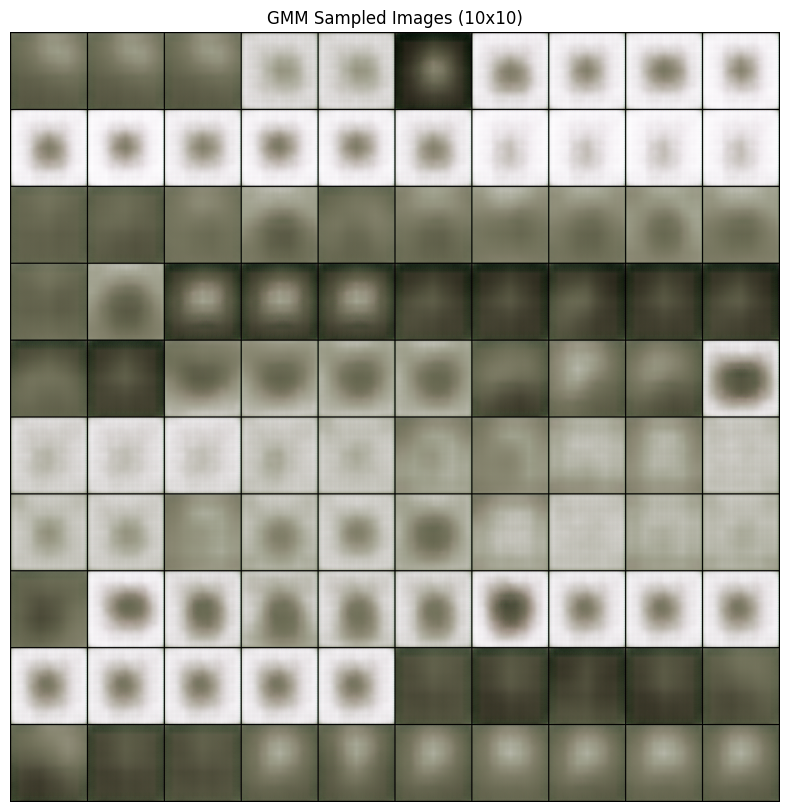

In [45]:
# -------- CELL 15: GMM Sampling + Decode --------

print("Fitting GMM on VAE latent space...")
X_np = latent_vectors.numpy()

gmm = GaussianMixture(n_components=20)
gmm.fit(X_np)

print("Sampling GMM latents...")
samples = gmm.sample(100)[0]
samples = torch.tensor(samples).float().to(device)

generated = vae.decoder(samples)

grid = vutils.make_grid(generated.cpu(), nrow=10, normalize=True)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.title("GMM Sampled Images (10x10)")
plt.axis("off")
plt.show()
